In [1]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


import time

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

/Users/c-hasselris/opt/anaconda3/envs/Python3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df=df.drop('HourUTC', axis=1)
df=df.drop('PriceArea', axis=1)
df.columns

Index(['HourDK', 'Wind', 'Hydro', 'Solar', 'Power', 'Unknown_Production',
       'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh', 'Exchange', 'GridLoss',
       'SpotPriceDKK', 'SpotPriceEUR', 'hourly_temperature_2m',
       'precipitation', 'cloud_cover', 'hourly_wind_speed_10m'],
      dtype='object')

In [3]:
df_use=df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
       'SpotPriceDKK', 'hourly_temperature_2m',
       'cloud_cover', 'hourly_wind_speed_10m']]
df_use
#'Hydro','Unknown_Production',
       # 'ExchangeGreatBelt_MWh', 'Exchange', 'GridLoss' , 'SpotPriceEUR', 'precipitation', 

,HourDK,Wind,Solar,Power,GrossConsumptionMWh,SpotPriceDKK,hourly_temperature_2m,cloud_cover,hourly_wind_speed_10m
1,2022-01-01 00:00:00,1114.281163,0.022679,789.892353,1415.517875,346.540009,7.0,100,4.14
3,2022-01-01 01:00:00,1206.825676,0.022142,644.458331,1394.053760,307.350006,7.4,100,4.10
5,2022-01-01 02:00:00,1215.685368,0.020423,599.437590,1342.593361,313.670013,6.9,100,3.98
7,2022-01-01 03:00:00,1070.803483,0.024189,624.804126,1292.604709,329.959991,6.6,100,3.57
9,2022-01-01 04:00:00,899.497269,0.019869,650.523492,1261.550580,280.130005,6.7,100,3.01
...,...,...,...,...,...,...,...,...,...
37911,2024-02-29 19:00:00,1269.406780,0.603984,692.384290,1950.231822,402.510010,7.0,100,4.73
37913,2024-02-29 20:00:00,1295.941996,0.462586,699.232854,1856.984338,216.910004,6.8,100,4.74
37915,2024-02-29 21:00:00,1279.730675,0.429421,669.755253,1767.729341,186.720001,6.5,100,4.84
37916,2024-02-29 22:00:00,1233.604793,0.437171,605.839292,1654.056866,186.720001,6.5,100,4.82


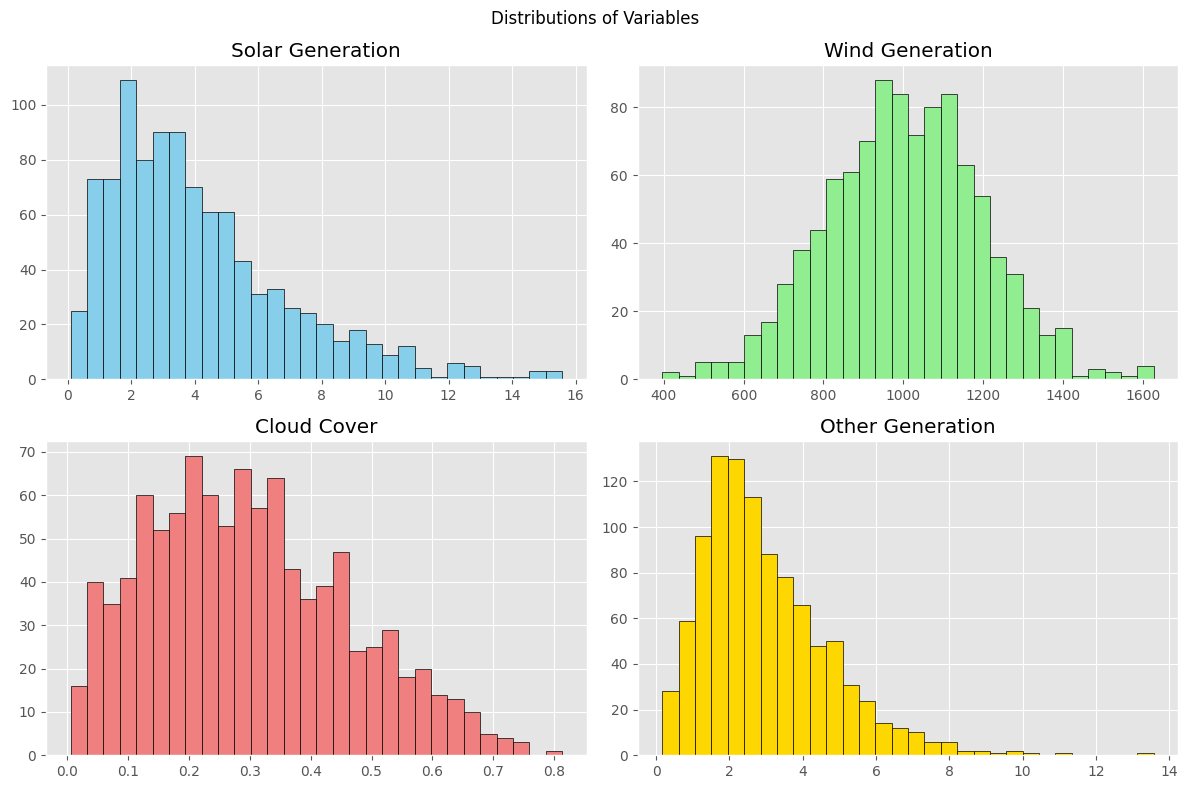

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data for each variable (replace these with your actual data)
num_samples = 1000

# Sample data for Solar Generation (Gamma distribution)
solar_shape = 2.0
solar_rate = 0.5
solar_samples = np.random.gamma(solar_shape, 1.0 / solar_rate, size=num_samples)

# Sample data for Wind Generation (Normal distribution)
wind_mean = 1000.0
wind_std = 200.0
wind_samples = np.random.normal(wind_mean, wind_std, size=num_samples)

# Sample data for Cloud Cover (Beta distribution)
cloud_alpha = 2.0
cloud_beta = 5.0
cloud_samples = np.random.beta(cloud_alpha, cloud_beta, size=num_samples)

# Sample data for Other Generation (Gamma distribution)
other_shape = 3.0
other_rate = 1.0
other_samples = np.random.gamma(other_shape, 1.0 / other_rate, size=num_samples)

# Create subplots for each variable
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot histograms for each variable
axs[0, 0].hist(solar_samples, bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Solar Generation')
axs[0, 1].hist(wind_samples, bins=30, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Wind Generation')
axs[1, 0].hist(cloud_samples, bins=30, color='lightcoral', edgecolor='black')
axs[1, 0].set_title('Cloud Cover')
axs[1, 1].hist(other_samples, bins=30, color='gold', edgecolor='black')
axs[1, 1].set_title('Other Generation')

# Add a title to the figure
fig.suptitle('Distributions of Variables')

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
# Calculate variance for cloud, solar, and wind
cloud_variance = df["cloud_cover"].var()
solar_variance = df["Solar"].var()
wind_variance = df["Wind"].var()

# Print the variances
print(f"Cloud cover variance: {cloud_variance:.0f}")
print(f"Solar generation variance: {solar_variance:.0f}")
print(f"Wind generation variance: {wind_variance:.0f}")

Cloud cover variance: 1483
Solar generation variance: 19066
Wind generation variance: 237211


In [6]:
# import matplotlib.pyplot as plt

# # Assuming your DataFrame is loaded as 'df'

# # Define desired variable names for stacked bar chart
# var_names = ['Solar', 'Wind', 'cloud_cover', 'Power']  # Assuming 'Other' represents a specific column

# # Extract data for each variable based on column names
# data_dict = {name: df[name] for name in var_names}

# # Create the stacked bar chart
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.stackplot(data_dict.keys(), data_dict.values(), labels=var_names, colors=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
# ax.set_title('Energy Production Breakdown')
# ax.set_xlabel('Samples (based on index)')
# ax.set_ylabel('Values')
# ax.legend(title='Energy Source')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.tight_layout()
# plt.show()

In [7]:
# import numpyro
# import numpyro.distributions as dist
# from numpyro import handlers
# from numpyro.infer import MCMC, NUTS

# import jax
# import jax.numpy as jnp
# from jax import random, vmap
# from jax.scipy.special import logsumexp
# from jax import lax

In [8]:
pip install jax

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install numpyro

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
# import numpyro
# import numpyro.distributions as dist

In [11]:

#   """
#   This model defines a probabilistic relationship between Wind, Solar, Power, 
#   and Gross Consumption using a partially directed structure.

#   Args:
#       data: A dictionary containing observed values for each variable.

#   Returns:
#       No return value, samples are collected within the model definition.
#   """

#   # Extract data
#   wind = df["Wind"]
#   solar = df["Solar"]
#   power = df["Power"]

#   # Define coefficients (assuming linear relationships for now)
#   beta_wind = pyro.sample(name="beta_wind", fn=dist.Normal(loc=0., scale=1.))
#   beta_solar = pyro.sample(name="beta_solar", fn=dist.Normal(loc=0., scale=1.))
#   beta_power = pyro.sample(name="beta_power", fn=dist.Normal(loc=0., scale=1.))

#   # Define a base distribution for gross consumption (can be adjusted based on your findings)
#   mu_0 = pyro.param(name="mu_0", default=0.0)  # Base mean
#   sigma_0 = pyro.param(name="sigma_0", default=1.0)  # Base standard deviation

#   # Model the gross consumption
#   gross_consumption = beta_wind * wind + beta_solar * solar + beta_power * power + mu_0
#   pyro.sample(
#       name="gross_consumption", fn=dist.Normal(loc=gross_consumption, scale=sigma_0), obs=data["GrossConsumptionMWh"]
#   )

# # Example usage (assuming you have your data loaded in a dictionary named 'data')
# model(data)


In [12]:
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# import numpy as np

# # Define train and test indices
# train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# # Define train and test sets
# train_data = df.loc[train_idx]
# test_data = df.loc[test_idx]

# X_train = train_data.drop(columns=['GrossConsumptionMWh'])
# y_train = train_data['GrossConsumptionMWh'].values

# X_test = test_data.drop(columns=['GrossConsumptionMWh'])
# y_test = test_data['GrossConsumptionMWh'].values

# # Define guide fuanction
# model = EnergyModel(n_in=X_train.shape[1], n_hidden=4, n_out=1) 
# guide = AutoDiagonalNormal(model)

# # Reset parameter values
# pyro.clear_param_store()

# # Define the number of optimization steps
# n_steps = 10000

# # Setup the optimizer
# adam_params = {"lr": 0.01}
# optimizer = ClippedAdam(adam_params)

# # Setup the inference algorithm
# elbo = Trace_ELBO(num_particles=1)
# svi = SVI(model, guide, optimizer, loss=elbo)

# # Do gradient steps
# train_losses = []
# for step in range(n_steps):
#     elbo = svi.step(torch.tensor(X_train.values, dtype=torch.float32), 
#                     torch.tensor(y_train, dtype=torch.float32))
#     train_losses.append(elbo)
#     if step % 500 == 0:
#         print("[%d] ELBO: %.1f" % (step, elbo))

# # Plot the training loss curve
# plt.plot(train_losses)
# plt.xlabel("Steps")
# plt.ylabel("ELBO")
# plt.title("Training Loss Curve")
# plt.show()


In [13]:
# from pyro.infer import Predictive

# # Get posterior samples for beta
# predictive = Predictive(model, guide=guide, num_samples=1000,
#                         return_sites=("beta",))
# samples = predictive(X_train.values, y_train)

# print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

# # Make predictions for test set
# predictive = Predictive(model, guide=guide, num_samples=1000,
#                         return_sites=("obs", "_RETURN"))
# samples = predictive(torch.tensor(X_test.values, dtype=torch.float32))

# y_pred = samples["obs"].mean(axis=0).detach().numpy()
# mae = np.mean(np.abs(y_test - y_pred))
# print("MAE:", mae)

# # Plot the true vs predicted values
# plt.scatter(y_test, y_pred)
# plt.xlabel("True Gross Consumption")
# plt.ylabel("Predicted Gross Consumption")
# plt.title("True vs Predicted Gross Consumption")
# plt.show()

In [14]:
import torch
import pandas as pd
import numpy as np
import pyro
import pyro.distributions as dist

In [15]:
def model(X, z1, z2, z3):
    # Define initial values for means
    
    # T_prev = X[0, 0]
    # C_prev = X[0, 1]
    # W_prev = X[0, 2]
    # O_prev = X[0, 3]

    # Define priors for model parameters
    # tau = pyro.sample("tau", dist.Normal(0, 1))
    # kappa = pyro.sample("kappa", dist.Normal(0, 1))
    # gamma = pyro.sample("gamma", dist.HalfCauchy(1))
    # omega = pyro.sample("omega", dist.Normal(0, 1))
    # sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    # rho_1 = pyro.sample("rho_1", dist.HalfCauchy(1))
    # rho_2 = pyro.sample("rho_2", dist.Normal(0, 1))
    # partial = pyro.sample("partial", dist.Normal(0, 1))
    # epsilon = pyro.sample("epsilon", dist.Normal(0, 1))
    # alpha = pyro.sample("alpha", dist.Normal(0, 1))
    # beta = pyro.sample("beta", dist.Normal(0, 1))

    tau = pyro.sample("tau", dist.HalfCauchy(1))
    kappa = pyro.sample("kappa", dist.HalfCauchy(1))
    gamma = pyro.sample("gamma", dist.HalfCauchy(1))
    omega = pyro.sample("omega", dist.HalfCauchy(1))
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    rho_1 = pyro.sample("rho_1", dist.HalfCauchy(1))
    rho_2 = pyro.sample("rho_2", dist.HalfCauchy(1))
    partial = pyro.sample("partial", dist.HalfCauchy(1))
    epsilon = pyro.sample("epsilon", dist.HalfCauchy(1))
    alpha = pyro.sample("alpha", dist.HalfCauchy(1))
    beta = pyro.sample("beta", dist.HalfCauchy(1))

    D_t_vector = torch.zeros(len(X))

    # For each time period t
    for t in range(1, len(X) + 1):
        # # Mean of temperature = don't draw, use previous period
        # T_t = T_prev

        # # Variance of temperature = z1
        # # Mean of Cloud cover = don't draw, use previous period
        # C_t = C_prev

        # # Variance of Cloud cover = z2
        # # Mean of Wind = don't draw, use previous period
        # W_t = W_prev

        # # Variance of Wind = z3
        # # Other generation = O_t
        # O_t = O_prev

        # Update previous values FROM TENSOR SO FORMAT WEIRD
        T_prev = X[t - 1, 0]  # Assuming temperature is the first column
        C_prev = X[t - 1, 1]  # Assuming cloud cover is the second column
        W_prev = X[t - 1, 2]  # Assuming wind speed is the third column
        O_prev = X[t - 1, 3]  # Assuming other generation is the fourth column

        # Draw samples for other variables
        T_t = pyro.sample(f"T_{t}", dist.Normal(T_prev, z1))
        C_t = pyro.sample(f"C_{t}", dist.Normal(C_prev, z2))
        W_t = pyro.sample(f"W_{t}", dist.Normal(W_prev, z3))
        S_t = pyro.sample(f"S_{t}", dist.Beta(abs(tau * T_t + kappa * C_t), gamma))
        
        Gw_t = pyro.sample(f"Gw_{t}", dist.Normal(omega * W_t, sigma))
        P_t = pyro.sample(f"P_{t}", dist.Normal(S_t * rho_1 + W_t * rho_2, partial))
        # D_t = pyro.sample(f"D_{t}", dist.Normal(beta * O_prev + epsilon * P_t, alpha))
        
        # Ensure that the scale parameter is positive by taking the absolute value
        D_t = pyro.sample(f"D_{t}", dist.Normal(beta * O_prev + epsilon * P_t, torch.abs(alpha)))
        D_t_vector[t - 1] = D_t

    return (D_t_vector)


In [16]:
df_use.columns

Index(['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
       'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover',
       'hourly_wind_speed_10m'],
      dtype='object')

In [17]:
num_total_obs = len(df_use)
num_train_obs = int(0.8 * num_total_obs)
num_test_obs = num_total_obs - num_train_obs

columns = ['hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'Power']

X_train = torch.tensor(df_use[columns][:num_train_obs].values, dtype=torch.float32)
X_test = torch.tensor(df_use[columns][num_train_obs:].values, dtype=torch.float32)


In [18]:
X_train


tensor([[  7.0000, 100.0000,   4.1400, 789.8923],
        [  7.4000, 100.0000,   4.1000, 644.4583],
        [  6.9000, 100.0000,   3.9800, 599.4376],
        ...,
        [ 13.0000,   1.0000,   4.9200,  80.3416],
        [ 12.8000,   1.0000,   4.9200,  80.0201],
        [ 12.8000,  16.0000,   4.9200,  76.8625]])

In [19]:
df_use["GrossConsumptionMWh"]

1        1415.517875
3        1394.053760
5        1342.593361
7        1292.604709
9        1261.550580
            ...     
37911    1950.231822
37913    1856.984338
37915    1767.729341
37916    1654.056866
37919    1566.990822
Name: GrossConsumptionMWh, Length: 18960, dtype: float64

In [20]:

# 4. Run the model for the training set
temp_var = df_use['hourly_temperature_2m'].var() #6.6392  # Set the value of z1
cloud_var = df_use['cloud_cover'].var()  # Set the value of z2
win_var = df_use['hourly_wind_speed_10m'].var()  # Set the value of z3



# pyro.clear_param_store()  # aClear parameter store before running the model
pred_demand = model(X_train, temp_var, cloud_var, win_var)


In [21]:
np.array(pred_demand)

array([1842.8137 , 1500.5037 , 1393.5516 , ...,  186.85576,  184.41179,
        179.57335], dtype=float32)

In [34]:
pred_actual = df_use["GrossConsumptionMWh"][:num_train_obs].values

In [35]:
pred_actual= pred_actual

In [36]:
torch.tensor(pred_actual)

tensor([1415.5179, 1394.0538, 1342.5934,  ..., 1212.9663, 1135.6820,
        1120.3859], dtype=torch.float64)

In [37]:
# Assuming df_use is your DataFrame containing the data
variance_temperature = df_use['hourly_temperature_2m'].var()
variance_cloud_cover = df_use['cloud_cover'].var()
variance_wind_speed = df_use['hourly_wind_speed_10m'].var()

print("Variance of Temperature:", variance_temperature)
print("Variance of Cloud Cover:", variance_cloud_cover)
print("Variance of Wind Speed:", variance_wind_speed)

Variance of Temperature: 44.08146685608273
Variance of Cloud Cover: 1482.9263884530535
Variance of Wind Speed: 4.23534777528591


Mean Absolute Percentage Error (MAPE): 35.91%
Mean Squared Error (MSE): 381202.19
Root Mean Squared Error (RMSE): 617.42


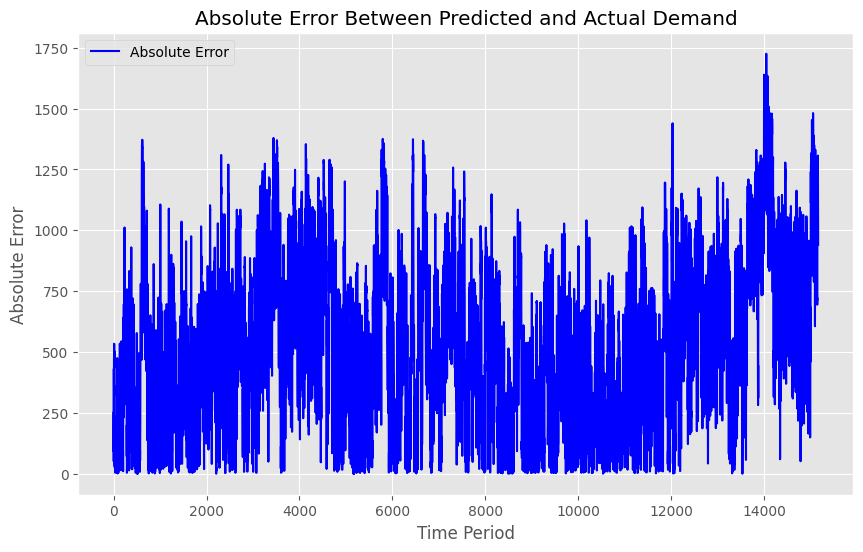

In [38]:
# Calculate absolute error
abs_error = torch.abs(pred_demand - pred_actual)

# Calculate Mean Absolute Percentage Error (MAPE)
actual = torch.tensor(pred_actual)
mape = torch.mean(torch.abs((actual - pred_demand) / actual)) * 100

# Calculate Mean Squared Error (MSE)
mse = torch.mean((pred_demand - actual) ** 2)

# Calculate Root Mean Squared Error (RMSE)
rmse = torch.sqrt(mse)

# Print error metrics
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Plot the absolute error
plt.figure(figsize=(10, 6))
plt.plot(abs_error, color='blue', label='Absolute Error')
plt.title('Absolute Error Between Predicted and Actual Demand')
plt.xlabel('Time Period')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
np.sqrt(pred_demand.var()), torch.mean(pred_demand)

(tensor(607.7627), tensor(1165.3004))

In [49]:
np.sqrt(pred_actual.var()), np.mean(pred_actual)

(283.7509421162235, 1502.4549882495385)

In [39]:
np.array(pred_demand)[0:10],pred_actual[0:10]

(array([1842.8137, 1500.5037, 1393.5516, 1454.3148, 1515.5133, 1321.5791,
        1497.8533, 1579.3402, 1820.7671, 1703.6394], dtype=float32),
 array([1415.517875, 1394.05376 , 1342.593361, 1292.604709, 1261.55058 ,
        1231.723792, 1273.265994, 1308.530874, 1344.570144, 1401.806261]))

In [28]:
(np.array(pred_demand), pred_actual[0:10])

(array([1842.8137 , 1500.5037 , 1393.5516 , ...,  186.85576,  184.41179,
         179.57335], dtype=float32),
 array([141.5517875, 139.405376 , 134.2593361, 129.2604709, 126.155058 ,
        123.1723792, 127.3265994, 130.8530874, 134.4570144, 140.1806261]))

In [29]:
correlation = np.corrcoef(pred_demand, pred_actual)[0, 1]
print(correlation)


0.5286730897589154
